# Covariance estimation

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numpy.linalg import eigh
from mne import Epochs, pick_types
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.event import find_events

from pyriemann.estimation import Covariances
from pyriemann.utils.distance import distance
from pyriemann.classification import MDM, TSclassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [8]:
%matplotlib inline

## Qualitative assessment of the covariance estimator with synthetic data

In [9]:
Nt, Nc, Ns = 10, 5, 1000
diags = 2.0 + 0.1 * np.random.randn(Nt, Nc)
A = 2*np.random.rand(Nc, Nc) - 1
A /= np.atleast_2d(np.sqrt(np.sum(A**2, 1))).T
true_cov = np.empty(shape=(Nt, Nc, Nc))
X = np.empty(shape=(Nt, Nc, Ns))
for i in range(Nt):
    true_cov[i] = A.dot(np.diag(diags[i])).dot(A.T)
    X[i] = np.random.multivariate_normal(np.array([0.] * Nc), true_cov[i], size=Ns).T

estimators = ['lwf', 'oas', 'sch']
w_len = np.linspace(10, Ns, 100, dtype=np.int)
dist_true = np.zeros(shape=(len(estimators), len(w_len), Nt))
for i, e in enumerate(estimators):
    for j, t in enumerate(w_len):
        cov_est = Covariances(estimator=e).transform(X[:, :, :t])
        for k in range(Nt):
            dist_true[i, j, k] = distance(cov_est[k], true_cov[k], metric='riemann')

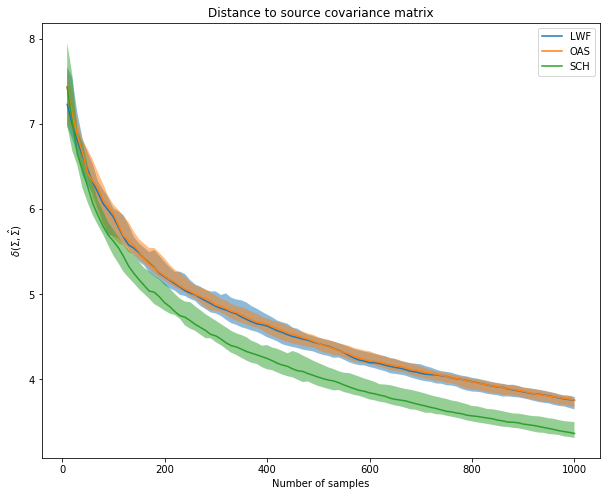

In [10]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10, 8)
for i, e in enumerate(estimators):
    ax.plot(w_len, np.median(dist_true[i, :, :], axis=1), '-', label=e.upper())
    ax.fill_between(w_len, np.percentile(dist_true[i, :, :], q=90, axis=1), 
                    np.percentile(dist_true[i, :, :], q=10, axis=1), alpha=0.5)
ax.set_title('Distance to source covariance matrix')
ax.set_xlabel('Number of samples')
ax.set_ylabel(r'$\delta(\Sigma, \hat{\Sigma})$')
_= ax.legend()

## Loading PhysioNet dataset

In [11]:
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_files = [read_raw_edf(f, preload=True, stim_channel='auto') for f in eegbci.load_data(subject,
             runs)]
raw = concatenate_raws(raw_files)

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')
# subsample elecs
picks = picks[::2]

# Apply band-pass filter
raw.filter(7., 35., method='iir', picks=picks, skip_by_annotation='edge')

events = find_events(raw, shortest_event=0, stim_channel='STI 014')

Extracting edf Parameters from /Users/sylchev/src/datasets/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from /Users/sylchev/src/datasets/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from /Users/sylchev/src/datasets/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 7 - 35 Hz
Setting up ban

## Estimator influence on covariance matrices conditioning 

In [12]:
estimators = ['lwf', 'oas', 'scm', 'sch']
tmin = -0.2
w_len = np.linspace(0.2, 2, 10)
n_trials = 45
cond_nb = np.zeros(shape=(len(estimators), len(w_len), n_trials))

for i, e in enumerate(estimators):
    for j, t in enumerate(w_len):
        epochs = Epochs(raw, events, event_id, tmin, tmin+t, proj=True, picks=picks,
                baseline=None, preload=True, verbose=False)
        cov = Covariances(estimator=e).transform(epochs.get_data())
        for k in range(len(cov)):
            w, _ = eigh(cov[k, :, :])
            cond_nb[i, j, k] =  w[-1] / w[0]

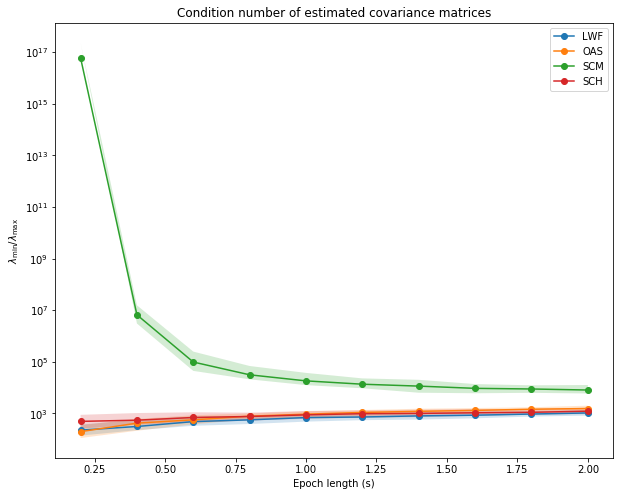

In [13]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10, 8)
for i, e in enumerate(estimators):
    ax.semilogy(w_len, np.median(cond_nb[i, :, :], axis=1), '-o', label=e.upper())
    ax.fill_between(w_len, np.percentile(cond_nb[i, :, :], q=90, axis=1), 
                    np.percentile(cond_nb[i, :, :], q=10, axis=1), alpha=0.2)
ax.set_title('Condition number of estimated covariance matrices')
ax.set_xlabel('Epoch length (s)')
ax.set_ylabel(r'$\lambda_{\min}$/$\lambda_{\max}$')
ax.legend()

## Picking a good estimator for classification

In [14]:
estimators = ['lwf', 'oas', 'scm', 'sch']
tmin = -0.2
w_len = np.linspace(0.1, 1, 10)
n_trials, n_splits = 45, 10
acc = np.zeros(shape=(len(estimators), len(w_len), n_splits))

cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
for i, e in enumerate(estimators):
    clf = make_pipeline(Covariances(estimator=e),
                        TSclassifier(metric='riemann'))
    for j, t in enumerate(w_len):
        epochs = Epochs(raw, events, event_id, tmin, tmin+t, proj=True, picks=picks,
                baseline=None, preload=True, verbose=False)
        X, y = epochs.get_data(), list()
        ev = epochs.events
        for k in range(len(ev)):
            if ev[k, -1] == 2: y.append(0)
            elif ev[k, -1] == 3: y.append(1)
        y = np.array(y)
        try:
            acc[i, j, :] = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
        except ValueError:
            print ('Wrong covariance estimation with ', e, ':', t, 's not sufficent to estimate a PSD matrix')
            acc[i, j, :] = [np.nan]*n_splits

/Users/sylchev/src/github/pyRiemann/pyriemann/utils/base.py:12: RuntimeWarning: invalid value encountered in log
  eigvals = numpy.diag(operator(eigvals))
/Users/sylchev/src/github/pyRiemann/pyriemann/utils/base.py:12: RuntimeWarning: invalid value encountered in log
  eigvals = numpy.diag(operator(eigvals))


Wrong covariance estimation with  scm : 0.1 s not sufficent to estimate a PSD matrix
Wrong covariance estimation with  scm : 0.2 s not sufficent to estimate a PSD matrix


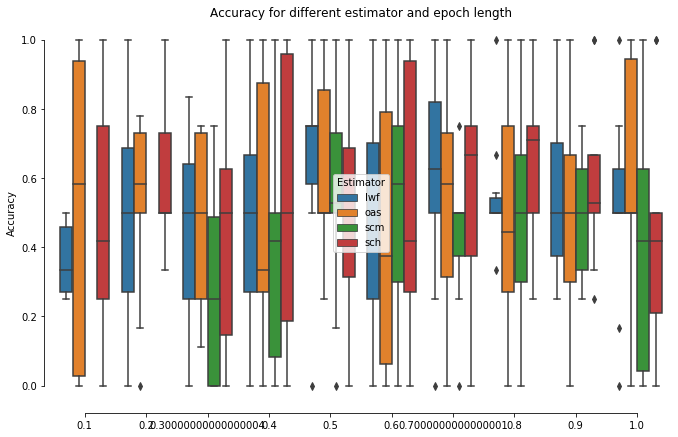

In [15]:
d = pd.DataFrame(index=range(n_splits),
                 columns=pd.MultiIndex.from_product(
                     iterables=[[str(e) for e in w_len.tolist()], estimators],
                     names=['Epoch length', 'Estimator']),
                 data=np.zeros(shape=(n_splits, len(estimators)*len(w_len))))
for i, c in enumerate([str(e) for e in w_len.tolist()]):
    d.loc[0:10, (str(c), 'lwf')] = acc[0, i, :]
    d.loc[0:10, (str(c), 'oas')] = acc[1, i, :]
    d.loc[0:10, (str(c), 'scm')] = acc[2, i, :]
    d.loc[0:10, (str(c), 'sch')] = acc[3, i, :]
b = d.unstack(level=0).reset_index(level=2, drop=True).reset_index(name='data')
plt.figure(figsize=(11, 7))
_ = sns.boxplot(x='Epoch length', y='data', hue="Estimator", data=b)
plt.title("Accuracy for different estimator and epoch length")
plt.ylabel('Accuracy')
plt.xlabel('')
sns.despine(offset=10, trim=True)
# plt.tight_layout(0.5)


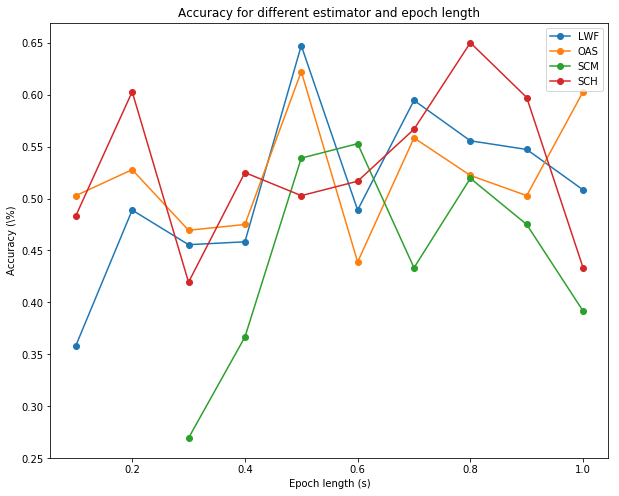

In [16]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10, 8)
for i, e in enumerate(estimators):
    ax.plot(w_len, np.mean(acc[i, :, :], axis=1), '-o', label=e.upper())
#    ax.fill_between(w_len, np.percentile(acc[i, :, :], q=75, axis=1), 
#                    np.percentile(acc[i, :, :], q=25, axis=1), alpha=0.2)
ax.set_title('Accuracy for different estimator and epoch length')
ax.set_xlabel('Epoch length (s)')
ax.set_ylabel(r'Accuracy (\%)')
ax.legend()